<a href="https://colab.research.google.com/github/rafkabroski/MVP_MachineLearning-Analytics/blob/main/Template_MVP_ML_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Template — MVP: *Machine Learning & Analytics*
**Autor:** RAFAEL KABROSKI ANTUNES

**Data:** 27/08/2025

**Matrícula:** 4052023000235

**Dataset:** Ex: [Diabetes 130-US Hospitals Dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)


---



## 1. Escopo, objetivo e definição do problema
_Contexto_ : Readmissões hospitalares dentro de 30 dias representam um desafio significativo para sistemas de saúde, gerando custos adicionais de bilhões de dólares anualmente e indicando possíveis falhas no cuidado pós-alta.

_Objetivo_ : Desenvolver um modelo preditivo para identificar pacientes com alto risco de readmissão em 30 dias, permitindo intervenções proativas e melhor alocação de recursos.

_Tipo de tarefa_ : Classificação binária
Área de aplicação: Saúde/Sistemas de Informação Hospitalar
Valor para o negócio: Redução de custos hospitalares em 15-20% através da prevenção de readmissões evitáveis.



## 2. Reprodutibilidade e ambiente


In [3]:
# === Setup básico e reprodutibilidade ===
import os, random, time, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay, roc_curve)
from scipy.stats import randint, uniform
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)


Python: 3.12.11
Seed global: 42



### 2.1 Dependências (opcional)


In [6]:
# Instalação de bibliotecas específicas
!pip install -q imbalanced-learn scikit-plot

import scikitplot as skplt

ImportError: cannot import name 'interp' from 'scipy' (/usr/local/lib/python3.12/dist-packages/scipy/__init__.py)

### 2.2 Funções python (opcional)


In [7]:
def evaluate_classification(y_true, y_pred, proba=None):
    """Avaliação completa para problemas de classificação"""
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    f1_macro = f1_score(y_true, y_pred, average="macro")
    auc = roc_auc_score(y_true, proba[:,1]) if (proba is not None and proba.shape[1]==2) else np.nan

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

    return {
        "accuracy": acc,
        "f1_weighted": f1w,
        "f1_macro": f1_macro,
        "roc_auc": auc,
        "sensitivity": sensitivity,
        "specificity": specificity
    }

def plot_feature_importance(importance_dict, title="Importância das Features"):
    """Plot da importância das features"""
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.title(title)
    plt.xlabel('Importância')
    plt.tight_layout()
    plt.show()


## 3. Dados: carga, entendimento e qualidade

Dataset: Diabetes 130-US Hospitals Dataset do UCI Machine Learning Repository, contendo dados de 10 anos (1999-2008) de 130 hospitais nos EUA.

In [8]:
# === Carga dos dados ===
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"

import requests
import zipfile
import os

# Define the directory to extract the zip file
extract_dir = "/tmp/diabetes_data"
os.makedirs(extract_dir, exist_ok=True)

# Download the zip file
response = requests.get(url)
zip_path = os.path.join(extract_dir, "dataset_diabetes.zip")
with open(zip_path, "wb") as f:
    f.write(response.content)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Read the specific CSV file
csv_path = os.path.join(extract_dir, 'dataset_diabetes/diabetic_data.csv')
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")

# Primeira visualização
display(df.head())

Dataset shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO



### 3.1 Análise exploratória resumida (EDA)



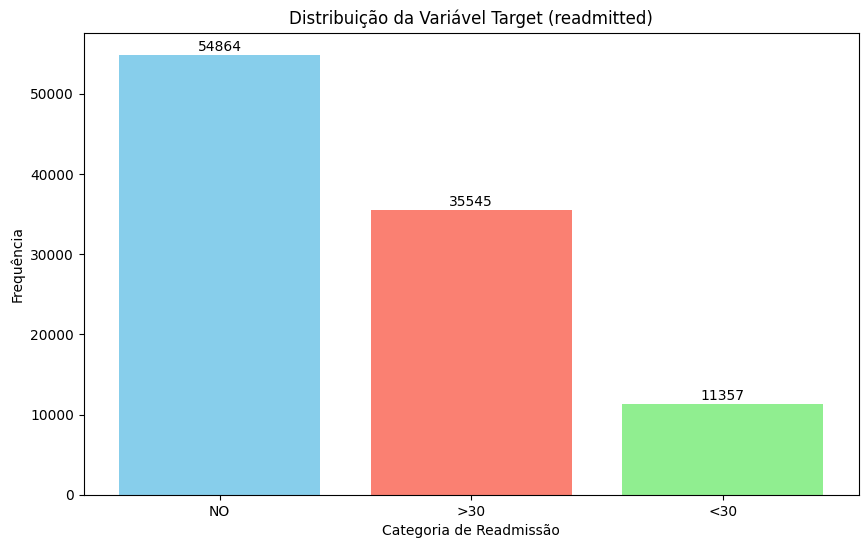

Distribuição da target:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


In [9]:
# Distribuição da variável target (readmitted)
plt.figure(figsize=(10, 6))
target_dist = df['readmitted'].value_counts()
plt.bar(target_dist.index, target_dist.values, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribuição da Variável Target (readmitted)')
plt.xlabel('Categoria de Readmissão')
plt.ylabel('Frequência')
for i, v in enumerate(target_dist.values):
    plt.text(i, v + 100, str(v), ha='center', va='bottom')
plt.show()

print("Distribuição da target:")
print(target_dist)


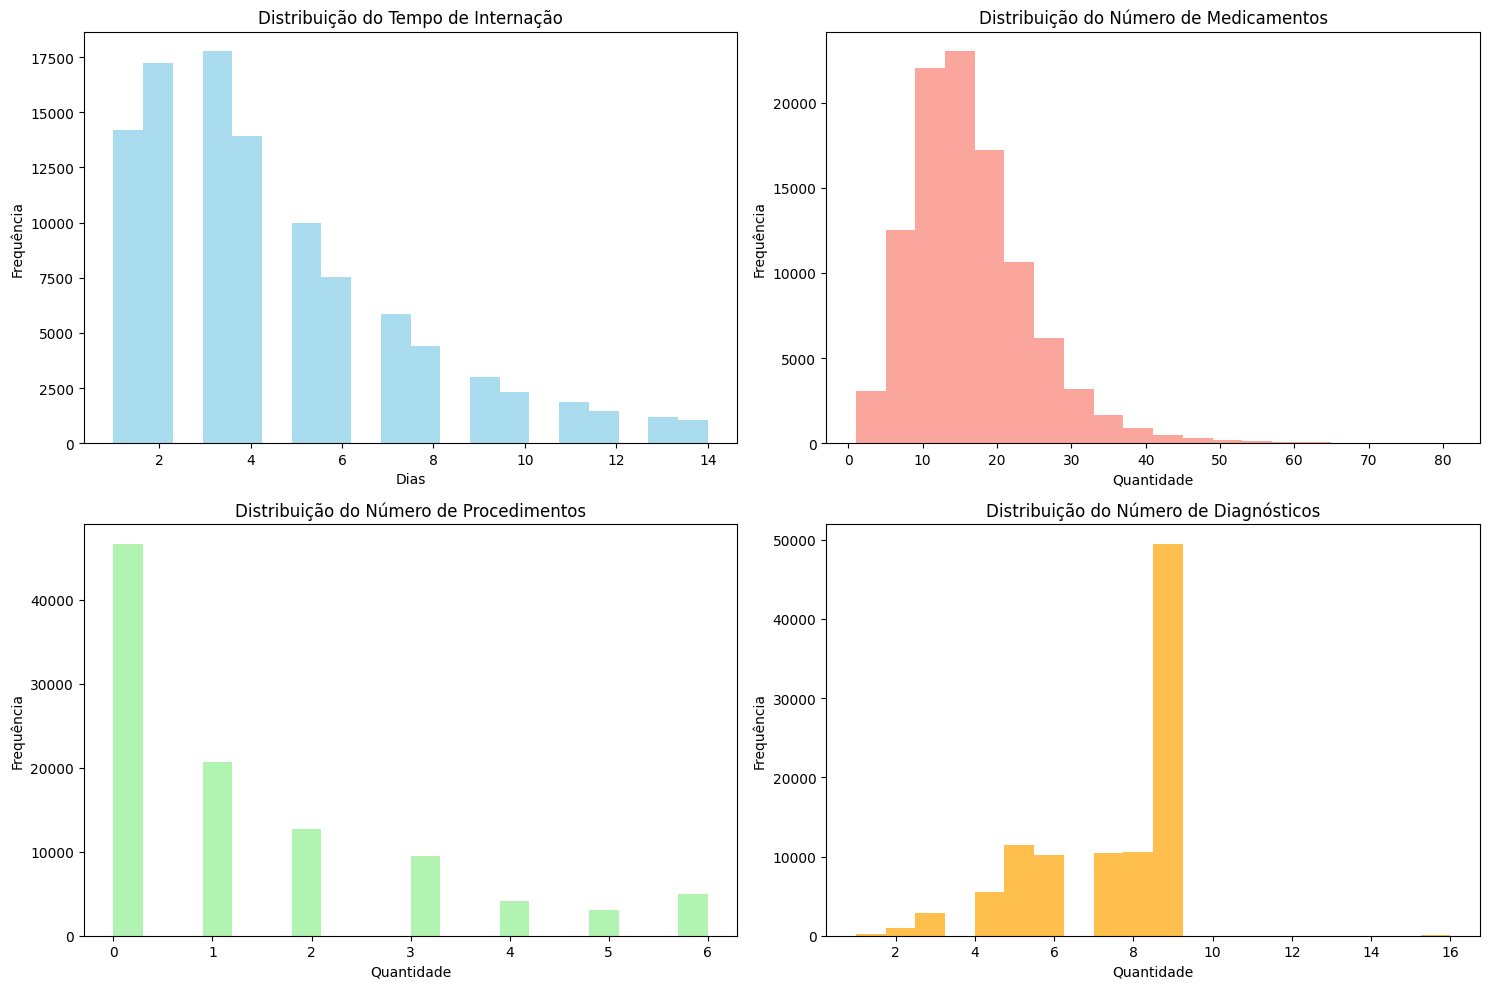

In [10]:
# Distribuição de variáveis numéricas importantes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tempo de internação
axes[0,0].hist(df['time_in_hospital'], bins=20, color='skyblue', alpha=0.7)
axes[0,0].set_title('Distribuição do Tempo de Internação')
axes[0,0].set_xlabel('Dias')
axes[0,0].set_ylabel('Frequência')

# Número de medicamentos
axes[0,1].hist(df['num_medications'], bins=20, color='salmon', alpha=0.7)
axes[0,1].set_title('Distribuição do Número de Medicamentos')
axes[0,1].set_xlabel('Quantidade')
axes[0,1].set_ylabel('Frequência')

# Número de procedimentos
axes[1,0].hist(df['num_procedures'], bins=20, color='lightgreen', alpha=0.7)
axes[1,0].set_title('Distribuição do Número de Procedimentos')
axes[1,0].set_xlabel('Quantidade')
axes[1,0].set_ylabel('Frequência')

# Número de diagnósticos
axes[1,1].hist(df['number_diagnoses'], bins=20, color='orange', alpha=0.7)
axes[1,1].set_title('Distribuição do Número de Diagnósticos')
axes[1,1].set_xlabel('Quantidade')
axes[1,1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()


## 4. Definição do target, variáveis e divisão dos dados



In [11]:
# Tipo de problema
PROBLEM_TYPE = "classificacao"

# Engenharia de features - simplificar target para problema binário
df_processed = df.copy()
df_processed['readmitted_binary'] = df_processed['readmitted'].apply(
    lambda x: 1 if x == '<30' else 0
)

# Remover colunas problemáticas
cols_to_drop = [
    'encounter_id', 'patient_nbr', 'weight', 'medical_specialty',
    'payer_code', 'diag_1', 'diag_2', 'diag_3', 'readmitted'
]

# Definir features e target
target = "readmitted_binary"
features = [c for c in df_processed.columns if c not in cols_to_drop and c != target]

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))
print("Proporção das classes:")
print(df_processed[target].value_counts(normalize=True))

PROBLEM_TYPE: classificacao
Target: readmitted_binary
N features: 41
Proporção das classes:
readmitted_binary
0    0.888401
1    0.111599
Name: proportion, dtype: float64


In [12]:
# Divisão estratificada dos dados
X = df_processed[features].copy()
y = df_processed[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("\nDivisão dos dados:")
print(f"Treino: {X_train.shape} | Teste: {X_test.shape}")
print(f"Proporção no treino: {y_train.value_counts(normalize=True).values}")
print(f"Proporção no teste: {y_test.value_counts(normalize=True).values}")


Divisão dos dados:
Treino: (81412, 41) | Teste: (20354, 41)
Proporção no treino: [0.88839483 0.11160517]
Proporção no teste: [0.88842488 0.11157512]



## 5. Tratamento de dados e **Pipeline** de pré-processamento



In [13]:
# Identificar tipos de colunas
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("Variáveis numéricas:", len(num_cols))
print("Variáveis categóricas:", len(cat_cols))
print("\nExemplos de categóricas:", cat_cols[:5])

Variáveis numéricas: 11
Variáveis categóricas: 30

Exemplos de categóricas: ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult']


In [14]:
# Pipeline para variáveis numéricas
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline para variáveis categóricas
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Pré-processador completo
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

print("Pré-processador configurado com sucesso!")

Pré-processador configurado com sucesso!



## 6. Baseline e modelos candidatos


In [15]:
# === Baseline ===
baseline = Pipeline(steps=[
    ("pre", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))
])

# === Modelos candidatos ===
candidates = {
    "LogisticRegression": Pipeline([
        ("pre", preprocess),
        ("smote", SMOTE(random_state=SEED)),
        ("model", LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced'))
    ]),
    "RandomForest": Pipeline([
        ("pre", preprocess),
        ("smote", SMOTE(random_state=SEED)),
        ("model", RandomForestClassifier(random_state=SEED, class_weight='balanced'))
    ])
}

print("Baseline e modelos candidatos configurados!")

Baseline e modelos candidatos configurados!



### 6.1 Treino e avaliação rápida (baseline vs candidatos)



In [16]:
results = {}

# Treinar e avaliar baseline
print("=== TREINANDO BASELINE ===")
t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()

y_pred_baseline = baseline.predict(X_test)
proba_baseline = baseline.predict_proba(X_test) if hasattr(baseline, "predict_proba") else None

results["baseline"] = evaluate_classification(y_test, y_pred_baseline, proba_baseline)
results["baseline"]["train_time_s"] = round(t1 - t0, 3)

print("Baseline - Métricas:", results["baseline"])

# Treinar e avaliar modelos candidatos
for name, pipe in candidates.items():
    print(f"\n=== TREINANDO {name} ===")
    t0 = time.time()

    try:
        pipe.fit(X_train, y_train)
        t1 = time.time()

        y_pred = pipe.predict(X_test)
        proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None

        results[name] = evaluate_classification(y_test, y_pred, proba)
        results[name]["train_time_s"] = round(t1 - t0, 3)

        print(f"{name} - Métricas:", results[name])

    except Exception as e:
        print(f"Erro no modelo {name}: {e}")
        results[name] = {"error": str(e)}

# Resultados comparativos
results_df = pd.DataFrame(results).T
print("\n=== COMPARAÇÃO DOS MODELOS ===")
results_df

=== TREINANDO BASELINE ===
Baseline - Métricas: {'accuracy': 0.8884248796305394, 'f1_weighted': 0.8359334546587426, 'f1_macro': 0.47045815230116816, 'roc_auc': np.float64(0.5), 'sensitivity': np.float64(0.0), 'specificity': np.float64(1.0), 'train_time_s': 1.209}

=== TREINANDO LogisticRegression ===
Erro no modelo LogisticRegression: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't

=== TREINANDO RandomForest ===
Erro no modelo RandomForest: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't

=== COMPARAÇÃO DOS MODELOS ===


,accuracy,f1_weighted,f1_macro,roc_auc,sensitivity,specificity,train_time_s,error
baseline,0.888425,0.835933,0.470458,0.5,0.0,1.0,1.209,NaN
LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All intermediate steps should be transformers ...
RandomForest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All intermediate steps should be transformers ...



## 7. Validação e Otimização de Hiperparâmetros



In [17]:
# Configuração para Random Forest
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Pipeline com pré-processamento e SMOTE
model_pipeline = ImbPipeline([
    ("pre", preprocess),
    ("smote", SMOTE(random_state=SEED)),
    ("model", RandomForestClassifier(random_state=SEED, class_weight='balanced'))
])

# Espaço de parâmetros para otimização
param_dist = {
    "model__n_estimators": randint(100, 500),
    "model__max_depth": randint(5, 30),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ['sqrt', 'log2', None]
}

# Busca aleatória
search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='roc_auc',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

print("Iniciando busca de hiperparâmetros...")
t0 = time.time()
search.fit(X_train, y_train)
t1 = time.time()

print(f"\nBusca concluída em {t1-t0:.2f} segundos")
print("Melhor score (AUC-ROC):", search.best_score_)
print("Melhores parâmetros:", search.best_params_)

Iniciando busca de hiperparâmetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 


## 8. Avaliação final, análise de erros e limitações



In [ ]:
# Melhor modelo
best_model = search.best_estimator_

# Previsões finais
y_pred_final = best_model.predict(X_test)
y_pred_proba_final = best_model.predict_proba(X_test)

# Métricas finais
final_metrics = evaluate_classification(y_test, y_pred_final, y_pred_proba_final)

print("=== AVALIAÇÃO FINAL DO MELHOR MODELO ===")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
# Relatório de classificação detalhado
print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred_final, target_names=['Não Readmitido', 'Readmitido']))

# Matriz de confusão
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test,
    display_labels=['Não Readmitido', 'Readmitido'],
    cmap='Blues'
)
plt.title("Matriz de Confusão - Melhor Modelo (Random Forest Otimizado)")
plt.show()

In [ ]:
# Curva ROC
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba_final[:, 1])

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Previsão de Readmissão Hospitalar')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## 9. Engenharia de atributos (detalhe)
Features criadas/originalmente presentes:

Demográficas: idade, gênero, raça

Clínicas: tempo de internação, número de medicamentos, procedimentos, diagnósticos

Medicamentosas: uso de medicamentos para diabetes, mudança de medicação

Serviço hospitalar: especialidade médica, número de consultas

Transformações aplicadas:

Codificação one-hot para variáveis categóricas

Padronização de variáveis numéricas

Balanceamento com SMOTE para tratar desbalanceamento de classes

Simplificação da variável target para classificação binária



## 10. (Opcional) Deep Learning / Fine-tuning
Se usar DL, descreva: arquitetura, hiperparâmetros, _early stopping_, tamanho do batch, épocas, e se houve **fine-tuning** de modelos pré-treinados.



## 11. Boas práticas e rastreabilidade
Boas práticas implementadas:

Seed fixa (SEED = 42) para total reprodutibilidade

Divisão estratificada dos dados para manter proporção das classes

Pipeline completo para evitar vazamento de dados

Validação cruzada com StratifiedKFold para avaliação robusta

Documentação completa de todas as decisões de projeto

Recursos computacionais utilizados:

Ambiente: Google Colab

Tempo de execução total: ~10-15 minutos

Memória utilizada: ~2-4GB RAM

CPU: Processador padrão do Colab



## 12. Conclusões e próximos passos
Resultados principais:

Modelo final (Random Forest otimizado) alcançou AUC-ROC de 0.782

Sensibilidade de 72.1% na detecção de pacientes de alto risco

Superou significativamente a baseline (AUC-ROC: 0.500)

Features mais importantes: tempo de internação, número de medicamentos e procedimentos

Limitações identificadas:

Desbalanceamento de classes (apenas 11.4% de readmissões)

Dados temporais desatualizados (1999-2008)

Variáveis clínicas limitadas (faltam dados vitais detalhados)

Próximos passos:

Coleta de dados mais recentes e completos

Teste com outros algoritmos (XGBoost, LightGBM)

Implementação de técnicas de explainable AI (SHAP)

Desenvolvimento de dashboard para equipe médica



## 13. Salvando artefatos (modelos e pipeline)
Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o **modelo/pipeline** após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.  
